In [2]:
# 모듈 임포트
import os
import torch
from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# 경로 설정
%cd ../Covid19-dataset/

c:\Users\User\Desktop\보경\졸업논문(생체의공)\Covid19-dataset


Dataloader 구현

In [4]:
# Custom Dataset 구현
from numpy import float32


class CustomDataset(Dataset):
    def readData(self):
        all_images = []
        all_labels = []
        
        class_names = os.walk(self.dataset_path).__next__()[1]
        
        for idx,class_name in enumerate(class_names):
            img_dir = os.path.join(self.dataset_path,class_name)
            img_names = os.walk(img_dir).__next__()[2]
            print('class name: {}, label: {}, num_images: {}'.format(class_name, idx, len(img_names)))
            
            for img_file in img_names:
                img_path = os.path.join(img_dir,img_file)
                image = Image.open(img_path)
                if image is not None:
                    all_images.append(img_path)
                    all_labels.append(idx)
                    
        return all_images, all_labels, len(all_images), len(class_names)
        
    def __init__(self, dataset_path, transforms=transforms.Resize((256,256))):
        self.dataset_path = dataset_path
        self.transforms = transforms
        self.images, self.labels, self.num_images, self.num_classes = self.readData()
        
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        # if label==0:
        #     label = [1,0,0]
        # elif label==1:
        #     label = [0,1,0]
        # else:
        #     label = [0,0,1]
        # label = np.array(label,dtype=float32)
        image = Image.open(image)
        image = image.convert('L') # gray scale
        
        if self.transforms is not None:
            image = self.transforms(image)
        
        return {'image':image, 'label':label}
    
    def __len__(self):
        return self.num_images
        

GradCam 확인하기 위한 모델 구현

In [5]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG,self).__init__()

        # get the trained vgg16 model
        self.PATH="../Covid19_image_classification_Kaggle/models/"
        self.vgg = torch.load(self.PATH+'cee_weights2/model_52.pt')
        self.vgg.load_state_dict(torch.load(self.PATH+'cee_weights2/model_state_52.pt'))
        self.checkpoint = torch.load(self.PATH+'cee_weights2/min_all_52.tar')
        self.vgg.load_state_dict(self.checkpoint['model'])

        # disect the network to access its last conv layer
        self.features_conv = self.vgg.features[:30]

        # get the pool layers of the feautres stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.gap = nn.AdaptiveAvgPool2d(output_size=(1,1))

        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier

        # place holder for the gradients
        self.gradients = None

        # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = self.gap(x)
        x = x.view((1,-1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)


In [6]:
# Data Loader 불러오기
test_transforms = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()])
test_dataset = CustomDataset('./test',test_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

class name: Covid, label: 0, num_images: 26
class name: Normal, label: 1, num_images: 20
class name: Viral Pneumonia, label: 2, num_images: 20


In [7]:
pwd

'c:\\Users\\User\\Desktop\\보경\\졸업논문(생체의공)\\Covid19-dataset'

./test\Covid\0100.jpeg
./test\Covid\0102.jpeg
./test\Covid\0105.png
./test\Covid\0106.jpeg
./test\Covid\0108.jpeg
./test\Covid\0111.jpg
./test\Covid\0112.jpg
./test\Covid\0113.jpg
./test\Covid\0115.jpeg
./test\Covid\0118.jpeg
./test\Covid\0119.jpeg
./test\Covid\0120.jpg
./test\Covid\094.png
./test\Covid\096.png
./test\Covid\098.jpeg
./test\Covid\auntminnie-2020_01_31_20_24_2322_2020_01_31_x-ray_coronavirus_US.jpg
./test\Covid\auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
./test\Covid\auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
./test\Covid\auntminnie-c-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
./test\Covid\auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg


c:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


./test\Covid\COVID-00003b.jpg
./test\Covid\COVID-00012.jpg
./test\Covid\COVID-00022.jpg
./test\Covid\COVID-00033.jpg
./test\Covid\COVID-00037.jpg
./test\Covid\radiopaedia-2019-novel-coronavirus-infected-pneumonia.jpg
./test\Normal\0101.jpeg
./test\Normal\0102.jpeg
./test\Normal\0103.jpeg
./test\Normal\0105.jpeg
./test\Normal\0106.jpeg
./test\Normal\0107.jpeg
./test\Normal\0108.jpeg
./test\Normal\0109.jpeg
./test\Normal\0110.jpeg
./test\Normal\0111.jpeg
./test\Normal\0112.jpeg
./test\Normal\0114.jpeg
./test\Normal\0115.jpeg
./test\Normal\0116.jpeg
./test\Normal\0117.jpeg
./test\Normal\0118.jpeg
./test\Normal\0119.jpeg
./test\Normal\0120.jpeg
./test\Normal\0121.jpeg
./test\Normal\0122.jpeg
./test\Viral Pneumonia\0101.jpeg
./test\Viral Pneumonia\0102.jpeg
./test\Viral Pneumonia\0103.jpeg
./test\Viral Pneumonia\0104.jpeg
./test\Viral Pneumonia\0105.jpeg
./test\Viral Pneumonia\0106.jpeg
./test\Viral Pneumonia\0107.jpeg
./test\Viral Pneumonia\0108.jpeg
./test\Viral Pneumonia\0109.jpeg
./test

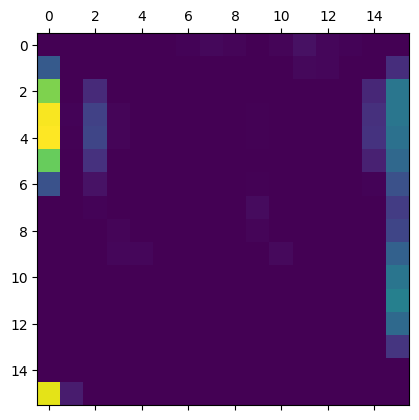

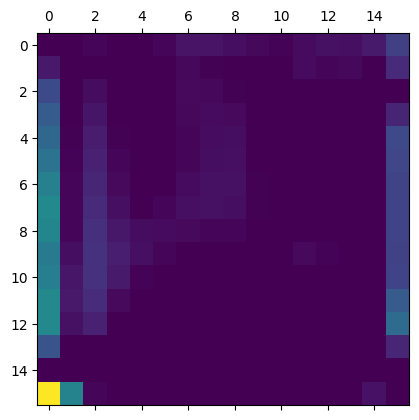

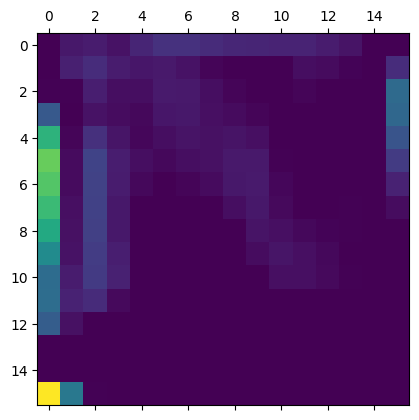

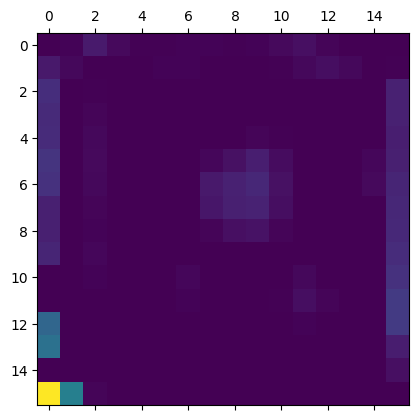

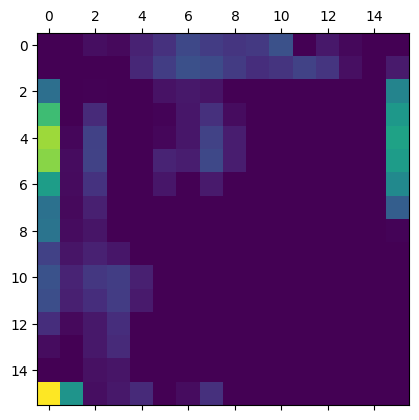

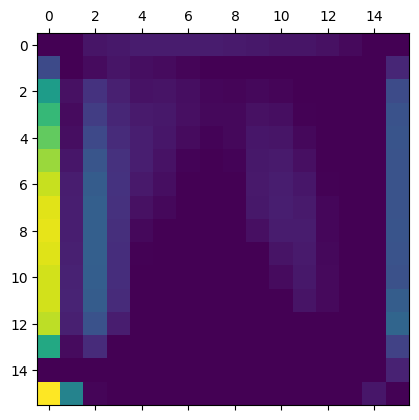

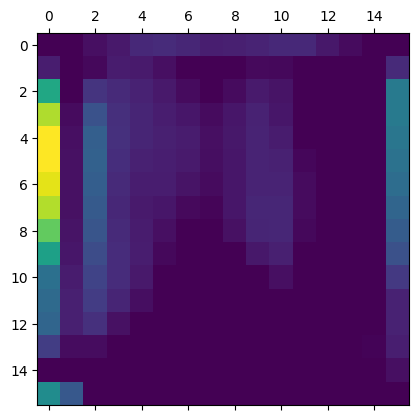

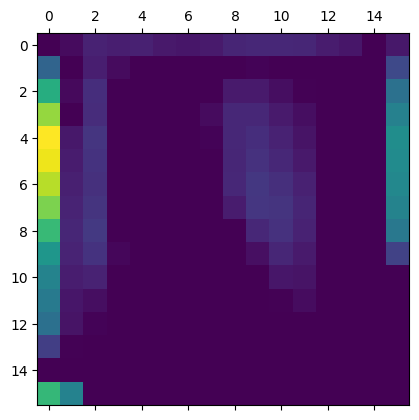

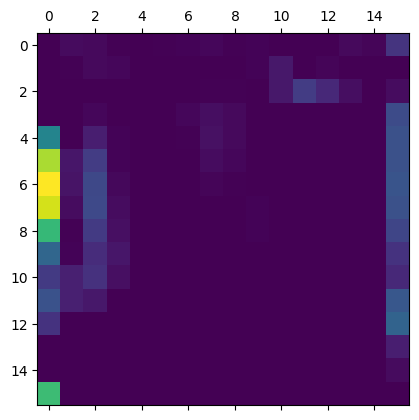

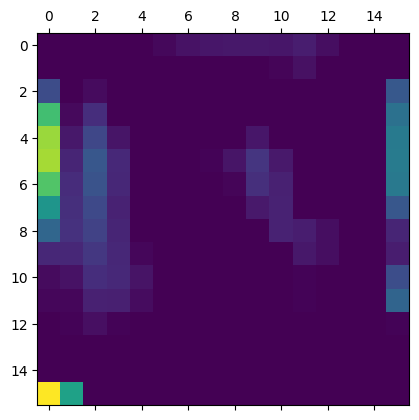

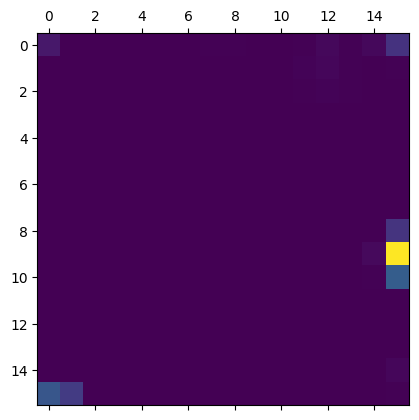

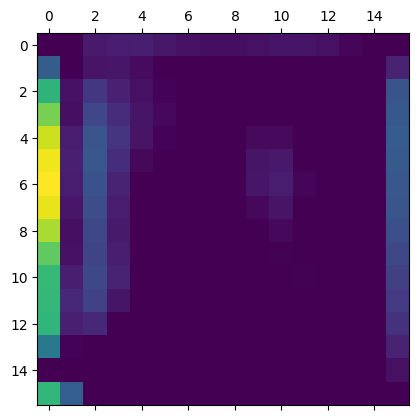

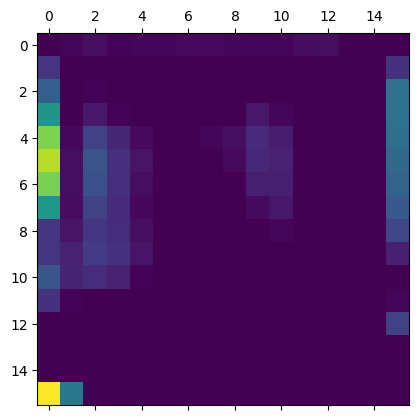

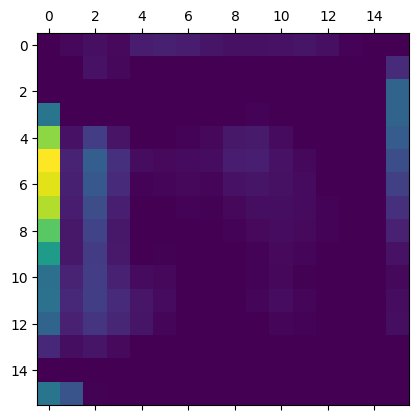

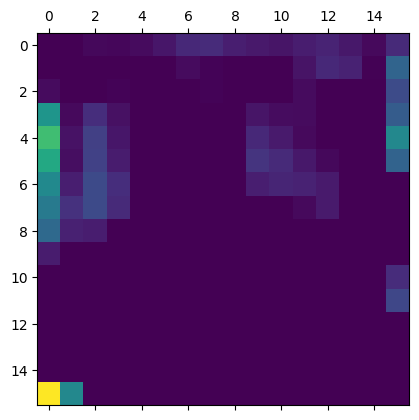

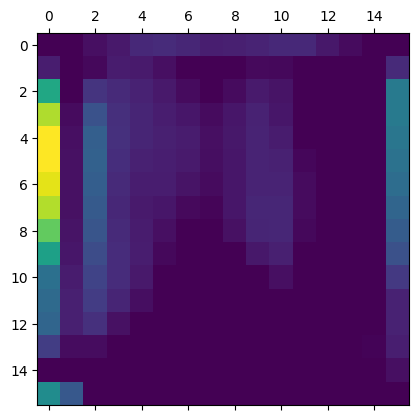

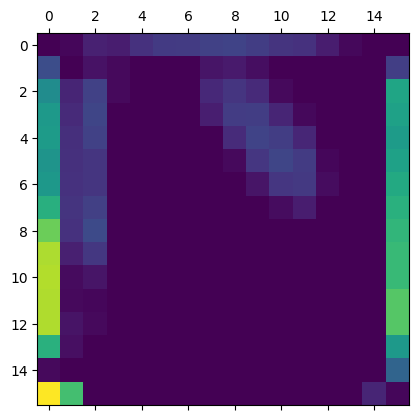

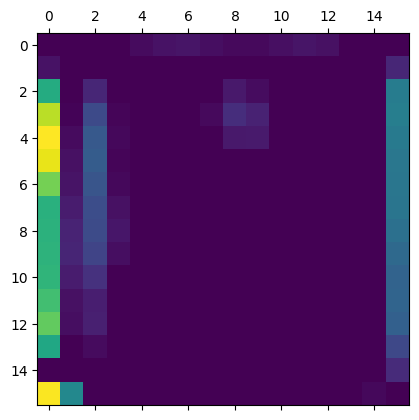

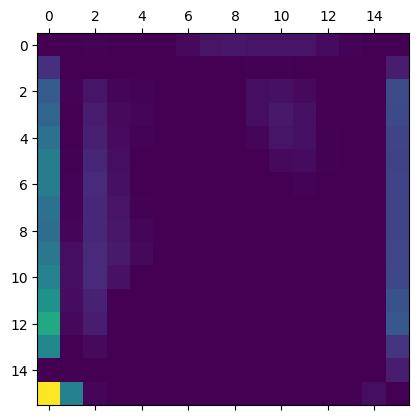

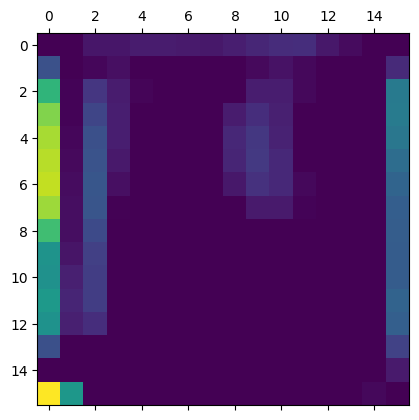

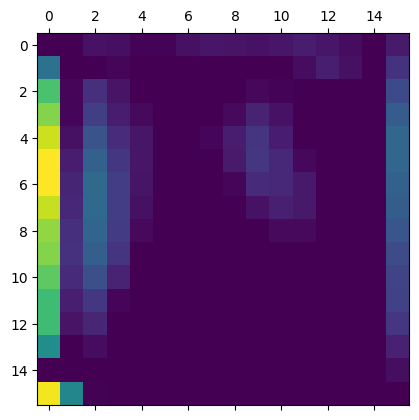

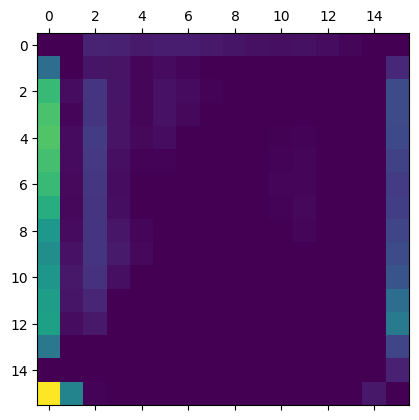

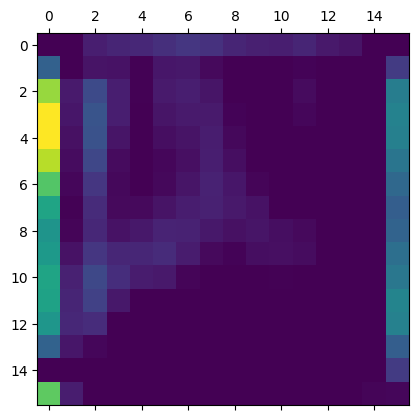

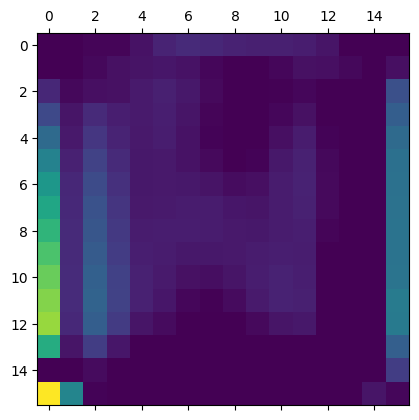

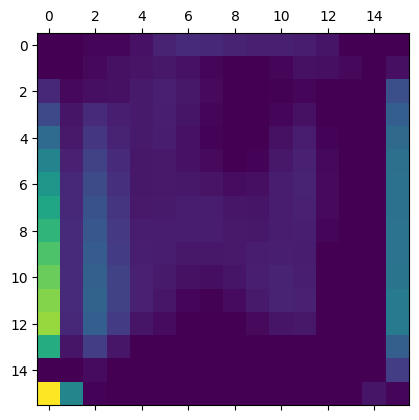

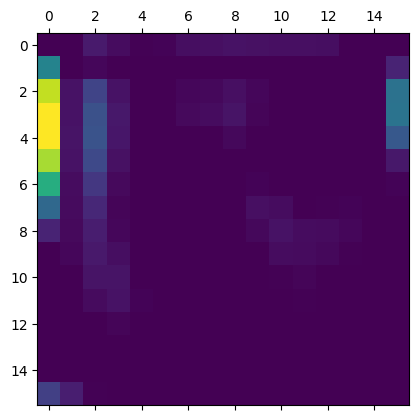

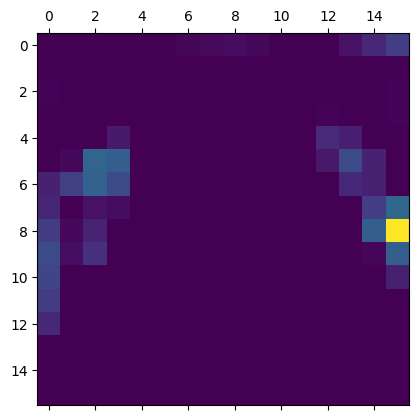

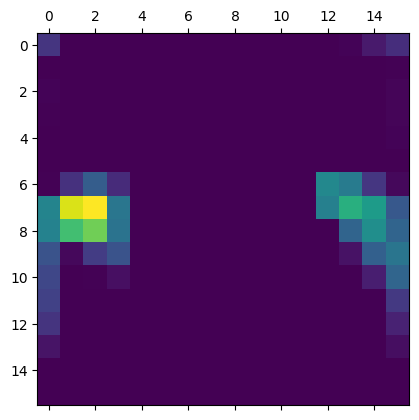

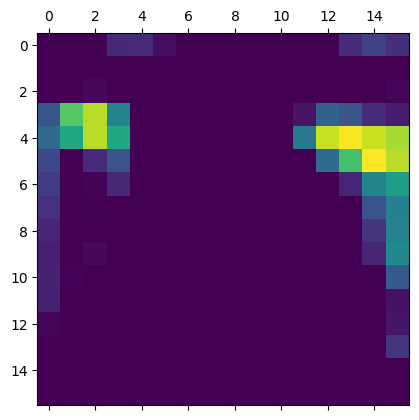

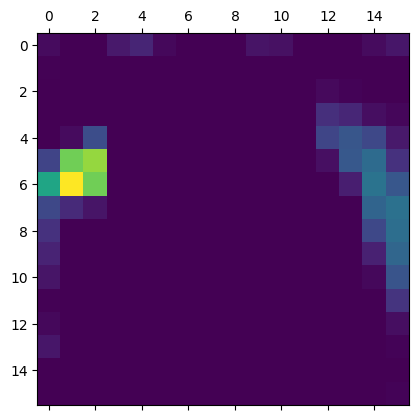

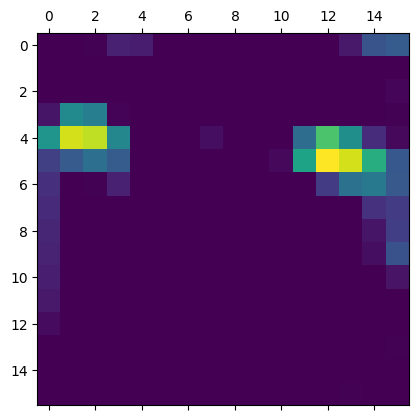

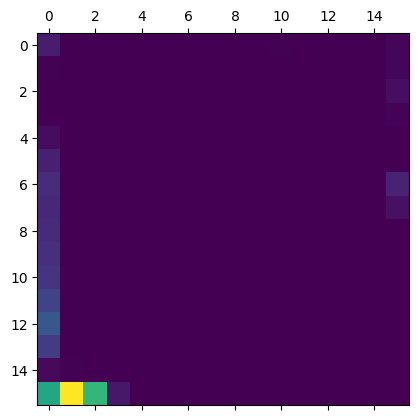

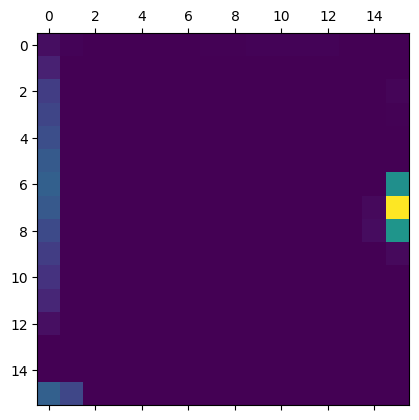

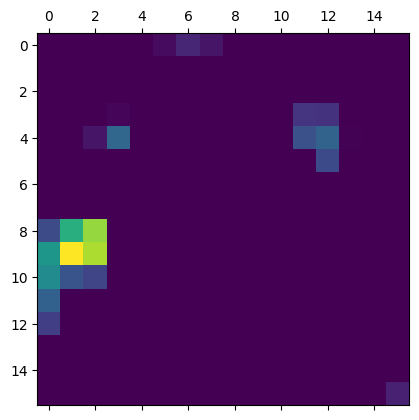

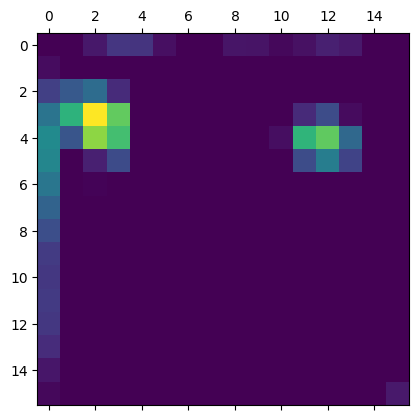

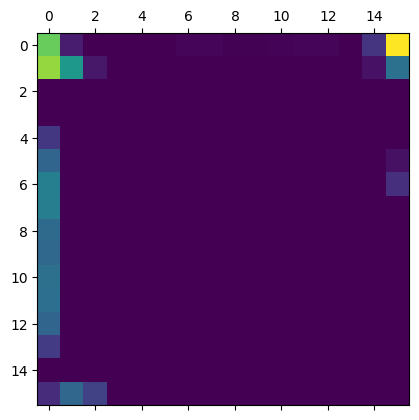

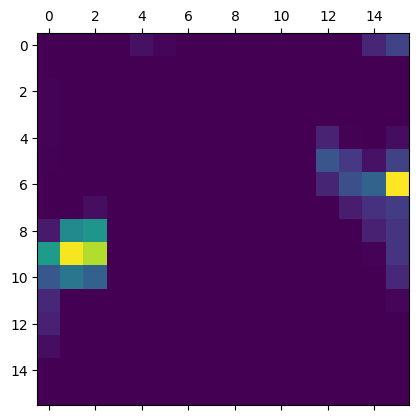

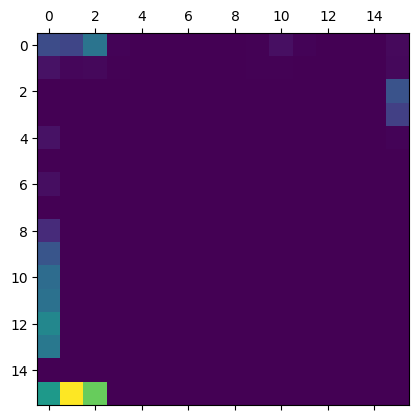

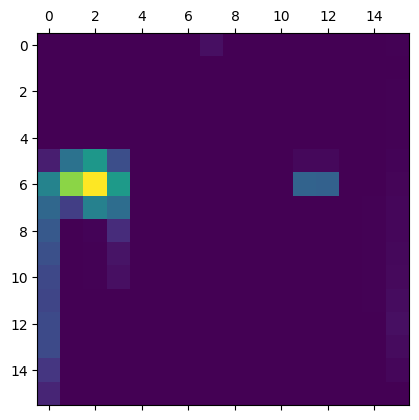

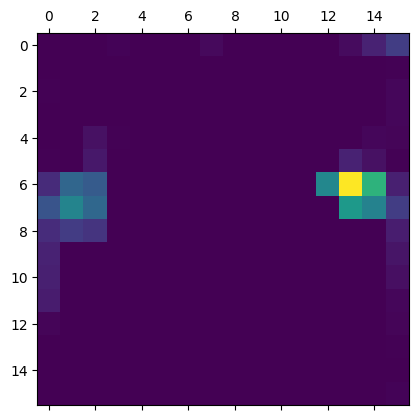

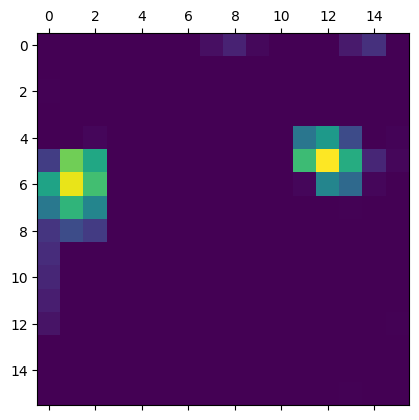

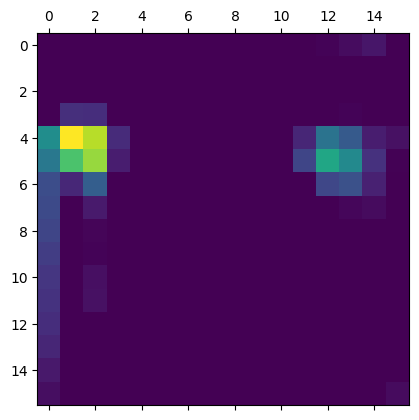

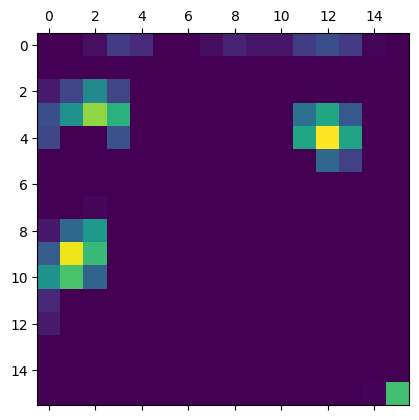

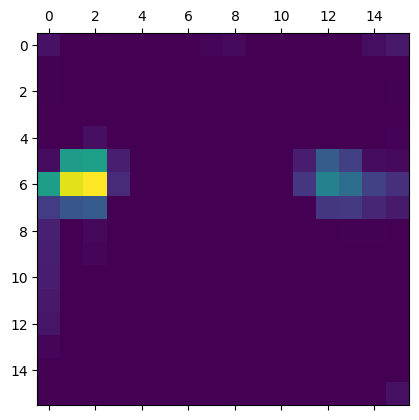

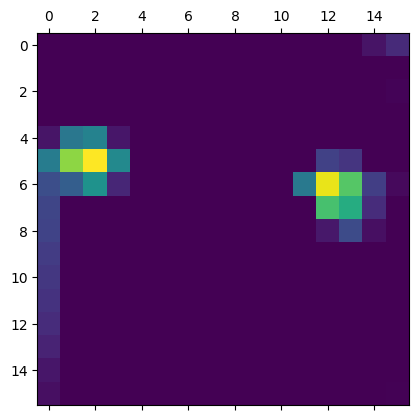

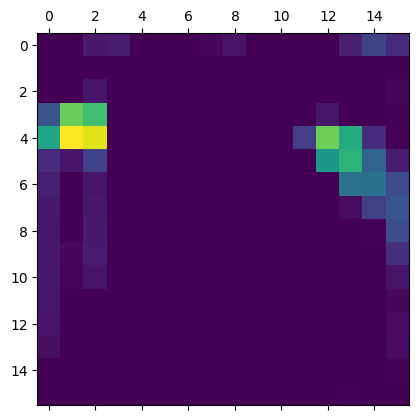

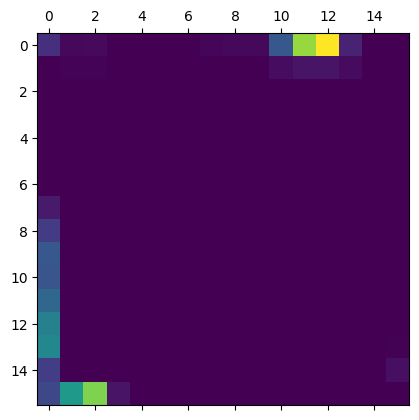

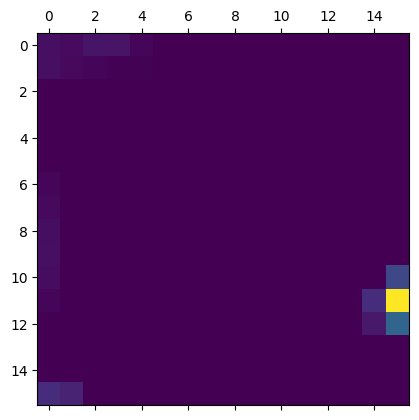

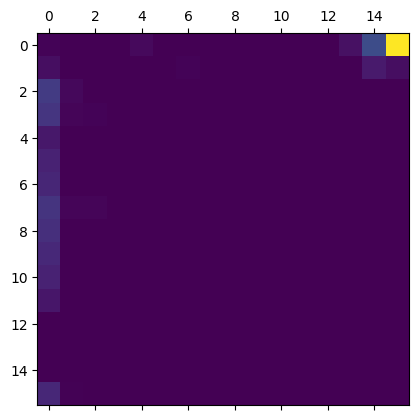

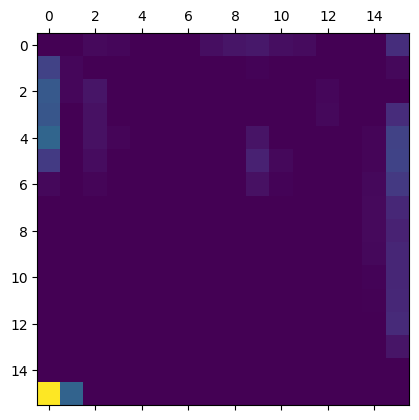

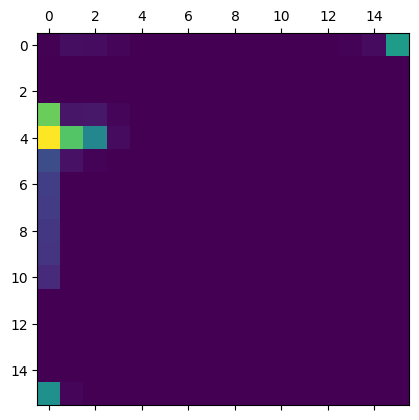

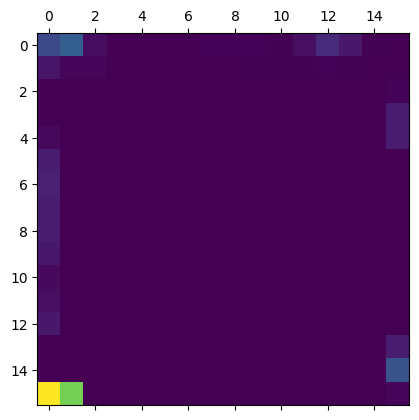

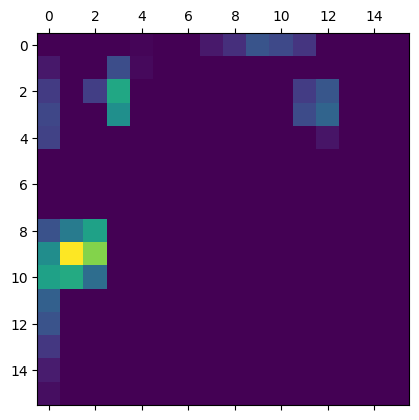

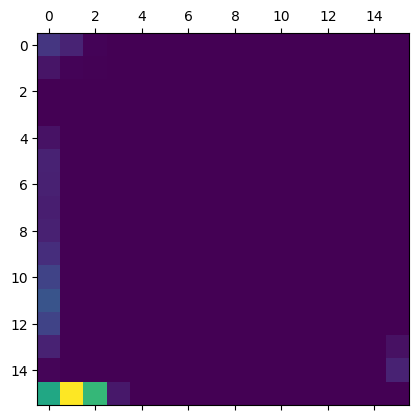

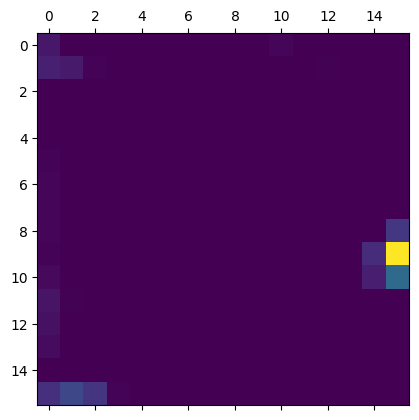

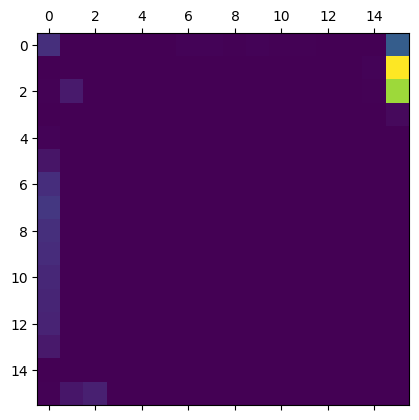

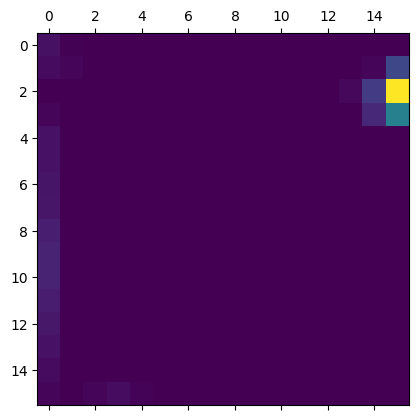

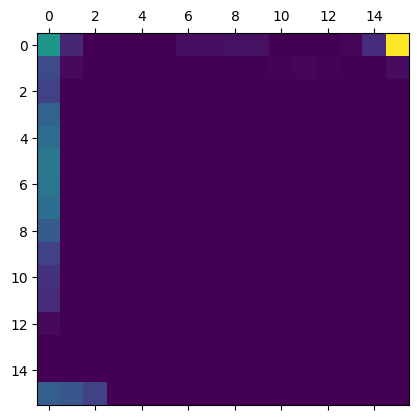

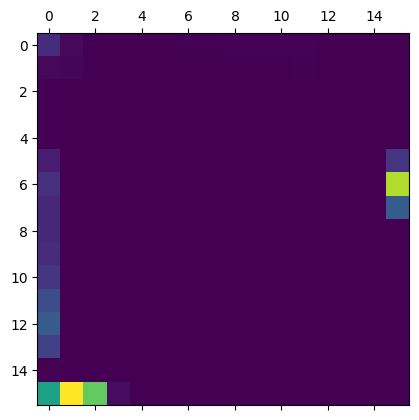

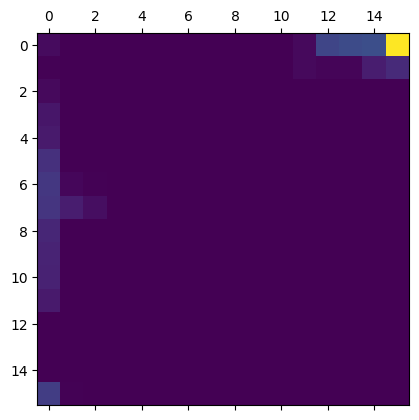

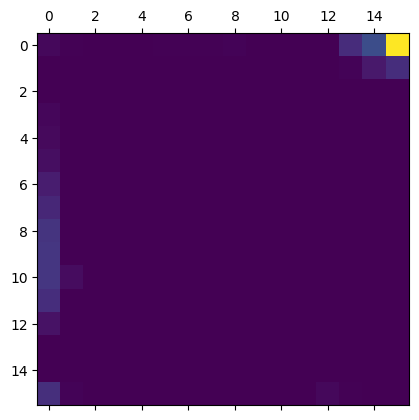

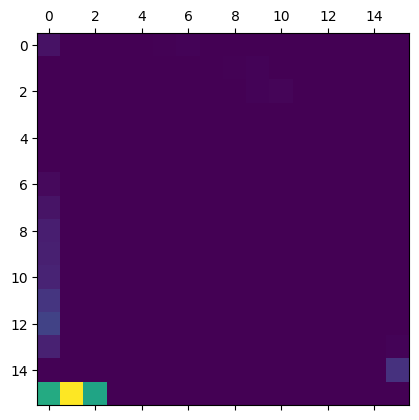

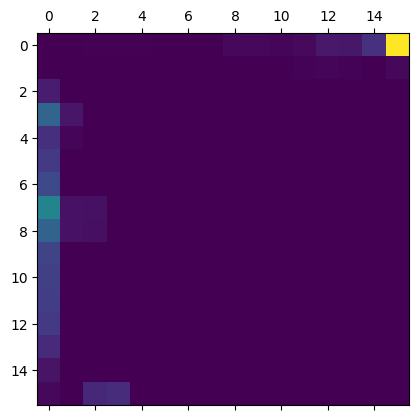

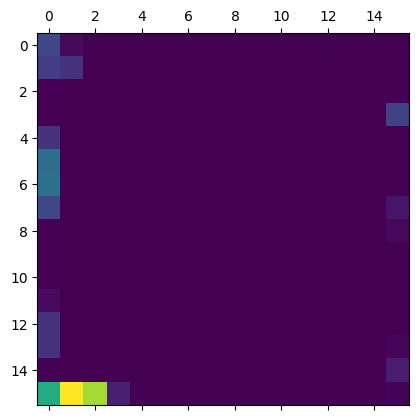

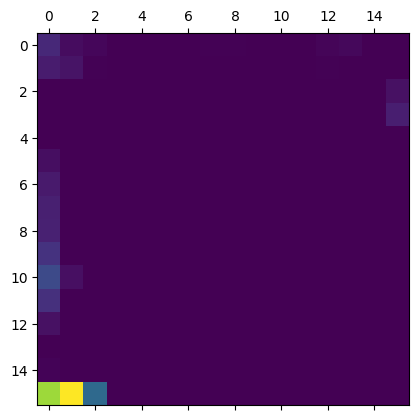

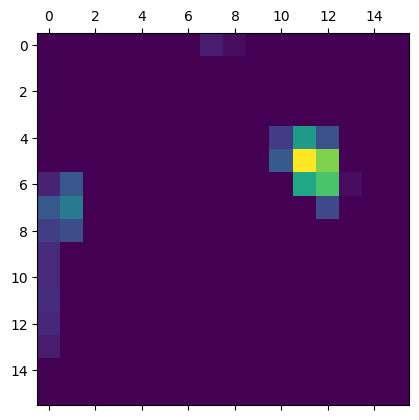

In [9]:
import cv2
# initialize the VGG model
vgg = VGG()

# set the evaluation mode
vgg.eval()

for idx, item in enumerate(test_loader):
    img = item['image']
    pred = vgg(img)

    class_name = pred.argmax(dim=1)
    pred[:,class_name].backward()

    # pull the gradients out of the model
    gradients = vgg.get_activations_gradient()

    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0,2,3])

    # get the activations of the last convolutional layer
    activations = vgg.get_activations(img).detach()

    # weight the channels by corresponding gradients
    for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]
        
    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap, 0)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    # plt.matshow(heatmap.squeeze())

    cam_name = str(idx)
    img_path = test_dataset.images[idx]
    print(img_path)
    img = cv2.imread(img_path)
    heatmap = heatmap.numpy()
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    cv2.imwrite('.grad_cam/map'+cam_name+'.jpg', superimposed_img)